# SRE ReAct Agent

This SRE agent uses **LangGraph** to autonomously investigate Kubernetes cluster issues. It connects to a **Model Context Protocol (MCP) server** for Kubernetes access, allowing an **LLM (GPT-5 mini)** to use kubectl commands as tools. The agent follows a **ReAct pattern** (Reason + Act) - it analyzes the hotel reservation service, calls K8s tools when needed, and provides diagnostic reports without human intervention.

**Key components:**
- **MCP Client**: Provides kubectl tools to the LLM
- **LangGraph**: Orchestrates the investigation workflow  
- **ReAct Loop**: Agent → Tools → Agent until diagnosis complete

The agent automatically starts investigating when triggered by the system prompt.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from langchain_openai import ChatOpenAI
gpt5 = ChatOpenAI(model="gpt-5")
gpt5mini = ChatOpenAI(model="gpt-5-mini")

# MCP Client for Kubernetes

MCP K8s server: [mcp-server-kubernetes](https://github.com/Flux159/mcp-server-kubernetes)

In [7]:
from langchain_mcp_adapters.client import MultiServerMCPClient

client = MultiServerMCPClient(
    {
        "kubernetes" : {
            "command": "npx",
            "args": ["mcp-server-kubernetes"],
            "transport": "stdio",
            "env": {
                "ALLOW_ONLY_NON_DESTRUCTIVE_TOOLS": "true"
            }
        }
    }
)

# NB: The cluster has to be running otherwise the tools won't be available
tools = await client.get_tools()

In [8]:
#list all the tools
for tool in tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_apply: Apply a Kubernetes YAML manifest from a string or file
🔧 kubectl_create: Create Kubernetes resources using various methods (from file or using subcommands)
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 kubectl_scale: Scale a Kubernetes deployment
🔧 kubectl_patch: Update field(s) of a resource using strategic merge patch, JSON merge patch, or JSON patch
🔧 kubectl_rollout: Manage the rollout of a resource (e.g., deployment, daemonset, statefulset)
🔧 kubectl_context: Manage Kubernetes contexts - list, get, or set the current context
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 install_helm_chart: Install a Helm chart
🔧 upgrade_helm_chart: Upgrade a Helm release
🔧 port_forward: Forward a local port to a port on a

In [20]:
sytem_prompt = """
    You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

    The service you are working with today is described below:
    {app_summary}

    You will use an MCP server which will provide you access to the kubernetes cluster.


    You will begin by analyzing the service's state and telemetry, and then submit your solution: describe the issue you have identified without fixing it!
    Also explain your reasoning and thought process behind the solution.
    """

app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [23]:
llm_with_tools = gpt5mini.bind_tools(tools, parallel_tool_calls=False)

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content=sytem_prompt.format(app_summary=app_summary))

# Node
async def sreAgent(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

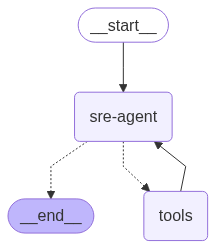

In [27]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("sre-agent", sreAgent)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "sre-agent")
builder.add_conditional_edges(
    "sre-agent",
    # If the latest message (result) from sre-agent is a tool call -> tools_condition routes to tools
    # If the latest message (result) from sre-agent is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "sre-agent")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
import time

async def test_async_graph(human_message: str):
    """Test the graph with proper async execution"""
    # Create a human message from the input
    messages = [HumanMessage(content=human_message)]
    
    # Start time tracking
    start_time = time.time()
    
    # Invoke the graph asynchronously
    result = await react_graph.ainvoke({"messages": messages}, {"recursion_limit": 50})
    
    # Calculate execution time
    execution_time = time.time() - start_time
    
    # Print results
    for m in result['messages']:
        m.pretty_print()
    
    # Calculate token usage
    total_tokens = 0
    input_tokens = 0
    output_tokens = 0
    
    for m in result['messages']:
        if hasattr(m, 'usage_metadata'):
            if m.usage_metadata:
                if 'input_tokens' in m.usage_metadata:
                    input_tokens += m.usage_metadata['input_tokens']
                if 'output_tokens' in m.usage_metadata:
                    output_tokens += m.usage_metadata['output_tokens']
                if 'total_tokens' in m.usage_metadata:
                    total_tokens += m.usage_metadata['total_tokens']

    result["total_tokens"] = total_tokens
    result["input_tokens"] = input_tokens
    result["output_tokens"] = output_tokens
    result["execution_time"] = execution_time
    
    print(f"\nExecution time: {execution_time:.2f} seconds")
    print(f"Token usage: {total_tokens} total ({input_tokens} input, {output_tokens} output)")
    
    return result

In [29]:
human = ""
result = await test_async_graph(human)

================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_SImOb0I9sPpVMV384ezD7bqz)
 Call ID: call_SImOb0I9sPpVMV384ezD7bqz
  Args:
    resourceType: namespaces
    name: 
    namespace: 
    allNamespaces: True
================================= Tool Message =================================
Name: kubectl_get

{
  "items": [
    {
      "name": "default",
      "namespace": "",
      "kind": "Namespace",
      "status": "Active",
      "createdAt": "2025-08-18T09:20:46Z"
    },
    {
      "name": "kube-node-lease",
      "namespace": "",
      "kind": "Namespace",
      "status": "Active",
      "createdAt": "2025-08-18T09:20:46Z"
    },
    {
      "name": "kube-public",
      "namespace": "",
      "kind": "Namespace",
      "status": "Active",
      "createdAt": "2025-08-18T09:20:46Z"
    },
    {
      "name": "kube-system",
      "namespace": "

In [ ]:
import os
import datetime
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

results_folder = "results"
os.makedirs(results_folder, exist_ok=True)

# Create the full path for the file
file_path = os.path.join(results_folder, f"{timestamp}.txt")

# Format and write messages to file
with open(file_path, 'w') as f:

    f.write(f"Total tokens used: {result['total_tokens']}\n")
    f.write(f"Input tokens: {result['input_tokens']}\n")
    f.write(f"Output tokens: {result['output_tokens']}\n\n")

    for i, message in enumerate(result['messages']):
        f.write(f"{'='*50}\nMESSAGE {i+1}\n{'='*50}\n")
        
        if isinstance(message, HumanMessage):
            f.write(f"Type: Human Message\n")
            f.write(f"Content: {message.content}\n\n")
        
        elif isinstance(message, AIMessage):
            f.write(f"Type: AI Message\n")
            if message.content:
                f.write(f"Content: {message.content}\n\n")
            
            if hasattr(message, 'additional_kwargs') and 'tool_calls' in message.additional_kwargs:
                tool_calls = message.additional_kwargs['tool_calls']
                f.write(f"Tool Calls ({len(tool_calls)}):\n")
                
                for idx, tool_call in enumerate(tool_calls):
                    f.write(f"  Tool Call {idx+1}: {tool_call['id']}\n")
                    if 'function' in tool_call:
                        f.write(f"    Function: {tool_call['function']['name']}\n")
                        f.write(f"    Arguments: {tool_call['function']['arguments']}\n\n")
        
        elif isinstance(message, ToolMessage):
            f.write(f"Type: Tool Response\n")
            f.write(f"Tool Call ID: {message.tool_call_id}\n")
            f.write(f"Content:\n{message.content}\n\n")
        
        else:
            f.write(f"Type: Other Message Type ({type(message).__name__})\n")
            f.write(f"Content: {str(message)}\n\n")

print(f"Messages exported to {file_path}")




Messages exported to results/20250818_120008.txt
